In [105]:
import librosa as li
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot

/home/krys/.local/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Sample rate:  22050
Sample type:  <class 'numpy.ndarray'>
Sample legth:  203213


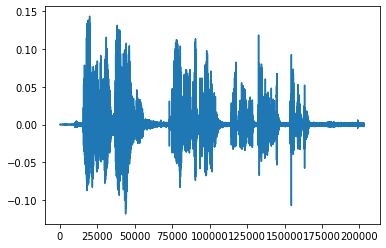

In [58]:
# Load sample 
soundSample, sr = li.load('vs1.mp3')

# Plot sample
pyplot.figure(1)
pyplot.plot(soundSample)

print("Sample rate: ", sr)
print("Sample type: " , type(soundSample))
print("Sample legth: " , len(soundSample))

<class 'numpy.ndarray'>
(257, 678)


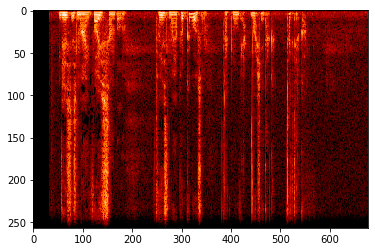

In [57]:
# Calculate the Short-Time Fourier Transformate
# n_fft = 512 for speech is recommened (default is 2048)
S = np.abs(librosa.stft(soundSample, n_fft=512, hop_length = 300))

# Switch to lagarytmic scale
S = librosa.power_to_db(S**2,ref=np.max)

pyplot.figure(1)
pyplot.imshow(S, cmap='gist_heat', aspect ='auto')

# Whot is the type of S ?
print(type(S))
print(S.shape)


(257, 257)


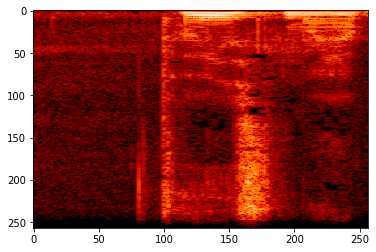

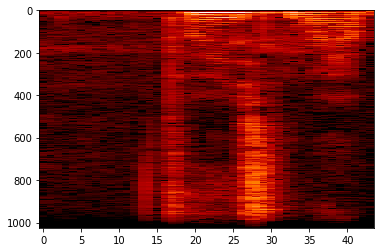

In [88]:
# Get 1 sek signal
# Calibrate the hop_length that the outup dimetions are equal 

fragment = 3
soundSample_s = soundSample[sr*fragment:sr*(1+fragment)]
S_s = np.abs(librosa.stft(soundSample_s, n_fft = 512, hop_length = round(sr/256))) # hop length adjusted
S_s = librosa.power_to_db(S_s**2,ref=np.max)

pyplot.figure(1)
pyplot.imshow(S_s, cmap='gist_heat', aspect ='auto')
print(S_s.shape)

fragment = 3
soundSample_s_no_hop = soundSample[sr*fragment:sr*(1+fragment)]
S_sno_hop = np.abs(librosa.stft(soundSample_s_no_hop))
S_sno_hop = librosa.power_to_db(S_sno_hop**2,ref=np.max)

pyplot.figure(2)
pyplot.imshow(S_sno_hop, cmap='gist_heat', aspect ='auto')

In [101]:
# Crop to 256x256 

print(S_s.shape)
print(S_s[0:256,0:256].shape)

Signal = S_s[0:256,0:256]
print(type(Signal))

signal_size = 256


(257, 257)
(256, 256)
<class 'numpy.ndarray'>


Directly konverted to torch.tensor:  torch.Size([256, 256]) <class 'torch.Tensor'>
After reshape:  torch.Size([256, 256]) <class 'torch.Tensor'>
Data type:  torch.float32
Convolution output:  torch.Size([1, 16, 128, 128])


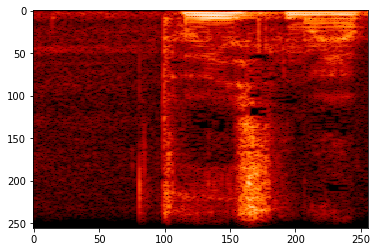

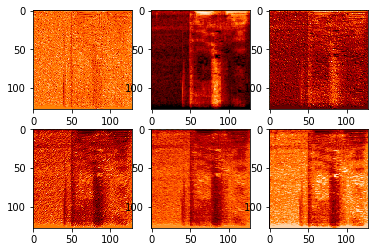

In [108]:
# Convert numpy to tensor

tsignal = torch.tensor(Signal)
print("Directly konverted to torch.tensor: " , tsignal.shape, type(tsignal))

pyplot.imshow(tsignal,cmap='gist_heat', aspect ='auto')


# Conv needs 4 arguments (4 dimentional tensor)
# View is tensor reshape (as reshape in numpy)
image_pro = tsignal.view(-1, 1, signal_size, signal_size)

print("After reshape: " , tsignal.shape, type(tsignal))
print("Data type: ", tsignal.dtype)


# Define convolution
convT = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
# Convolution input 
Cj2 = convT(image_pro)

print("Convolution output: ", Cj2.shape)

# We can't view the object that requires_gradient = True 
Cj2 = Cj2.detach()

# Convolutions plot (6 from 16)
pyplot.figure(2)
channel = 16
for i in range(0,6):
    pyplot.subplot(2,3,i+1)
    pyplot.imshow(Cj2[0,i],cmap='gist_heat', aspect ='auto')

In [106]:
import librosa as lr

# Create a dataset class

class VoiceSampleDataset(Dataset):
    """Voice Samples dataset."""

    def __init__(self, sample_name, root_dir = None, transform = None):

        self.soundSample, self.sr = lr.load(sample_name)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample